# 95-891 Homework 3 â€“ Computer Vision
Due Oct 27th, 2022

In this homework, we will implement [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks)-like deep, convolutional neural network (CNN) with PyTorch. We are going to use the CNN to classify flowers into the 102 categories.

The homework consists of the following parts:

- Load and prepare data.
- Load a pretrained Alexnet in PyTorch.
- Set up transfer learning for flower classification problem
- Train the model
- Model performance monitoring and analysis with learning curve
- Questions regarding the design choices

## The places requiring an input are marked with "???".

#### 1.1. Load the dataset which are in three folders, namely train, validation, and test

In [20]:
import matplotlib.pyplot as plt
from collections import OrderedDict

from copy import deepcopy
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

# download the data and unzip it. You should have three sets of data
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'


#### 1.2. Preview some images
Use PIL library to preview images

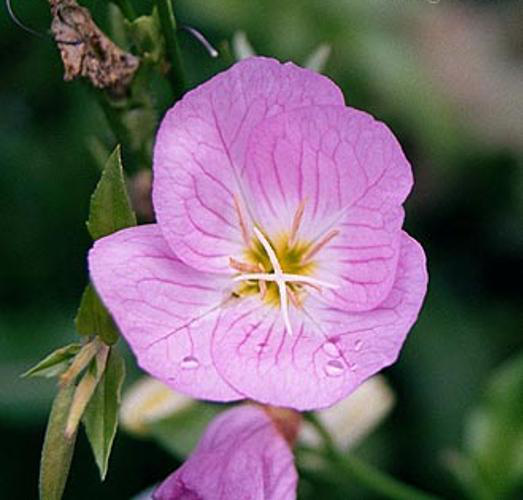

In [21]:
from PIL import Image  #show one example of image

Image.open("flowers/train/1/image_06734.jpg")

#### 1.3. Data transformation and processing

In [22]:
# Process with some data transformation, do not change
data_transforms = {
    'training': transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224,
                                                          0.225])]),

    'validation': transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])]),

    'testing': transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224,
                                                         0.225])])
}
# This decides how many images to process per training/validation
batch_size = 256

image_datasets = {
    'training': datasets.ImageFolder(train_dir,
                                     transform=data_transforms['training']),
    'testing': datasets.ImageFolder(test_dir,
                                    transform=data_transforms['testing']),
    'validation': datasets.ImageFolder(valid_dir,
                                       transform=data_transforms['validation'])
}

dataloaders = {
    'training': torch.utils.data.DataLoader(image_datasets['training'],
                                            batch_size=batch_size,
                                            shuffle=True),
    'testing': torch.utils.data.DataLoader(image_datasets['testing'],
                                           batch_size=batch_size,
                                           shuffle=False),
    'validation': torch.utils.data.DataLoader(image_datasets['validation'],
                                              batch_size=batch_size,
                                              shuffle=True)
}

# get the length of each dataloaders; wit batch size=256, you should have 26 batches of training samples, each with 256 images 
training_len = len(dataloaders['training'])
test_len = len(dataloaders['testing'])
validation_len = len(dataloaders['validation'])
class_to_idx = image_datasets['training'].class_to_idx

print('We have ', training_len, 'batches of training images;', 'each with',
      batch_size, 'images')
print('We have ', validation_len, 'batches of validation images;', 'each with',
      batch_size, 'images')

# Let us preview size of each batch
print('Single batch', next(iter(dataloaders['training']))[0].shape)

We have  26 batches of training images; each with 256 images
We have  4 batches of validation images; each with 256 images
Single batch torch.Size([256, 3, 224, 224])


### *Question 1: What is the effect of random flip and rotation in image data transformation?*
- How does it impact the training?
  By rotating and fliping the images randomly, it can expand the small and limited dataset of images by providing more
  variations of the available images without having to collect more dataset.
  Thus, the training would be more effective and more performant because the dataset is largely expanded.
- Why do not we apply them randomly at the validation or test time?
  Validation and test time are for validating the model, and no training is involved in these two phases.

### *Question 2: Explain the meaning of these numbers for a single batch?*
- 256: This means we have 256 images to process during each training/validation for a single batch.
- 3: This means the images in each batch have 3 different channels.
- 224: This means the images are cropped and now the input planes are 244 pixels in height.
- 224: This means the images are cropped and now the input planes are 244 pixels in width.

#### 1.4. Initialize the pretrained model

We are going to use an Alexnet convolutional neural network as our pretrained model. The architecture of the network is shown below
![picture](https://drive.google.com/uc?export=view&id=1XG8ZPxxcaOTaniTm-s_FdK4iRJbdMkhA)

Image credit: https://neurohive.io/en/popular-networks/alexnet-imagenet-classification-with-deep-convolutional-neural-networks/

In [24]:
# Transfer learning with alexnet
model = models.alexnet(pretrained=True)

### 1.5. Update the classifier of the model to be compatible with our datasets

In [25]:
# In transfer learning, we freeze the feature parameters from the original model
# The most straightforward way is to freeze their gradient update
# see https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html for how to set it
for param in model.parameters():
    param.requires_grad = False

print(model)

# This is the original classifier with alexnet
print()
print('Original classifier of Alexnet')
print(model.classifier)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
# now we need to replace the classifier by our datasets
# Note, fc2's out_feature should match our number of classes, which is 102

# Tip: check the original AlexNet classifier for some thoughts; they are similar.

# Defining number of hidden units in our fully connected layer
hidden_units = 4096
number_of_flowers = len(class_to_idx)

# Defining the fully connected layer that will be trained on the flower images
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(9216, hidden_units)), # this should be a Linear layer; how to connect with the pretrained model?
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.5)),
    ('fc2', nn.Linear(hidden_units, number_of_flowers)), # what is the output of this layer should be
    ('output', nn.LogSoftmax(dim=1))
]))


### *Question 3: Why are we using the Dropout layer in neural networks as shown above?*
- Explain it is usage briefly.
    
The reason why we are using the Dropout layer in neural networks is that this method can reduce the overfitting of neural
networks. 
    
    
- How does the dropout layer work during the prediction (evaluation) stage?

The Dropout layer can randomly select neurons and ignore them during trainings. In this particular training process, the  probability for a neuron to be ignored is 50%.
  

In [43]:
# double check if the classifier of the model is updated.
model.classifier = classifier
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu): ReLU()
    (dropout): Drop

### 1.6. Set up the configurations and train it!
- epochs = 30
- since it is a multiclassification problem, we use [negative log likelihood loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)
- we use the [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)
- learning rate (lr) = 0.001

In each epoch, we go through all the training samples to update the model, and evaluate with the validation samples to see how good the current model is.
- accuracy: mean of the matches in predicted class and the labels
- loss: negative log likelihood loss


**Sample outputs are provided below; but yours may vary**
**Your validation accuracy may be better than train; this is fine**

In [28]:
import copy
from copy import deepcopy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 30
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
criterion = nn.NLLLoss() # this is the loss
print_every = 5

validation_accuracies, training_accuracies = [], []
validation_losses, training_losses = [], []

best_validation_accuracy = 0
best_model_weights = None

for e in range(epochs):

    training_loss = training_accuracy = 0
    validation_loss = validation_accuracy = 0

    model.train()
    for batch_idx, (images, labels) in enumerate(dataloaders['training']):

        # Moving images & labels to the GPU if there is one
        images, labels = images.to(device), labels.to(device)

        # Pushing batch through network, calculating loss & gradient, and updating weights
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        # Calculating metrics
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(
            torch.FloatTensor)
        train_batch_accuracy = matches.mean()

        # Resetting optimizer gradient & tracking metrics
        optimizer.zero_grad()
        training_loss += loss.item()
        train_batch_loss = loss.item()
        training_accuracy += train_batch_accuracy.item()

        if batch_idx % print_every == 0:
            # First analyze the training statistics
            print('epoch', e, 'batch', batch_idx)
            print('training loss per batch', train_batch_loss)
            print('training accuracy per batch', train_batch_accuracy.item())

    # Then do the analysis for the validation only at the end of each training epochs
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(
                dataloaders['validation']):
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            ps = torch.exp(log_ps)
            top_ps, top_class = ps.topk(1, dim=1)
            matches = (top_class == labels.view(*top_class.shape)).type(
                torch.FloatTensor)
            validation_batch_accuracy = matches.mean()

            # Tracking validation metrics
            validation_loss += loss.item()
            validation_batch_loss = loss.item()
            validation_accuracy += validation_batch_accuracy.item()

    # Save the best model weights so far
    # Tip: see this https://pytorch.org/tutorials/beginner/saving_loading_models.html
    if validation_accuracy >= best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_model_weights = copy.deepcopy(model.state_dict())

    # Summary statistic per epoch
    print('epoch', e, 'summary')
    print('avg training loss per epoch', training_loss / training_len)
    print('avg training accuracy per epoch', training_accuracy / training_len)
    training_losses.append(training_loss / training_len)
    training_accuracies.append(training_accuracy / training_len)

    print('avg validation loss per epoch', validation_loss / validation_len)
    print('avg validation accuracy per epoch',
          validation_accuracy / validation_len)
    validation_losses.append(validation_loss / validation_len)
    validation_accuracies.append(validation_accuracy / validation_len)

    print()

epoch 0 batch 0
training loss per batch 4.8985443115234375
training accuracy per batch 0.0078125
epoch 0 batch 5
training loss per batch 13.870104789733887
training accuracy per batch 0.06640625
epoch 0 batch 10
training loss per batch 5.705898761749268
training accuracy per batch 0.1484375
epoch 0 batch 15
training loss per batch 3.4235661029815674
training accuracy per batch 0.20703125
epoch 0 batch 20
training loss per batch 3.1402571201324463
training accuracy per batch 0.2421875
epoch 0 batch 25
training loss per batch 2.3934879302978516
training accuracy per batch 0.40789473056793213
epoch 0 summary
avg training loss per epoch 6.514473135654743
avg training accuracy per epoch 0.17960051848338202
avg validation loss per epoch 1.7554521262645721
avg validation accuracy per epoch 0.5745703130960464

epoch 1 batch 0
training loss per batch 2.459383487701416
training accuracy per batch 0.40234375
epoch 1 batch 5
training loss per batch 2.3076043128967285
training accuracy per batch 0.

epoch 10 batch 10
training loss per batch 1.0691957473754883
training accuracy per batch 0.671875
epoch 10 batch 15
training loss per batch 1.0442156791687012
training accuracy per batch 0.70703125
epoch 10 batch 20
training loss per batch 1.1988365650177002
training accuracy per batch 0.671875
epoch 10 batch 25
training loss per batch 1.118198275566101
training accuracy per batch 0.6842105388641357
epoch 10 summary
avg training loss per epoch 1.0527238043454976
avg training accuracy per epoch 0.704500886110159
avg validation loss per epoch 0.46467259526252747
avg validation accuracy per epoch 0.8773437440395355

epoch 11 batch 0
training loss per batch 0.9237322211265564
training accuracy per batch 0.734375
epoch 11 batch 5
training loss per batch 0.9969016313552856
training accuracy per batch 0.703125
epoch 11 batch 10
training loss per batch 0.9882356524467468
training accuracy per batch 0.75
epoch 11 batch 15
training loss per batch 1.0160664319992065
training accuracy per batch 0.

epoch 20 batch 15
training loss per batch 0.9998546838760376
training accuracy per batch 0.7265625
epoch 20 batch 20
training loss per batch 0.9768369793891907
training accuracy per batch 0.72265625
epoch 20 batch 25
training loss per batch 0.6514777541160583
training accuracy per batch 0.8157894611358643
epoch 20 summary
avg training loss per epoch 0.9325509094274961
avg training accuracy per epoch 0.7462202677359948
avg validation loss per epoch 0.5080602467060089
avg validation accuracy per epoch 0.8938281238079071

epoch 21 batch 0
training loss per batch 0.7948752045631409
training accuracy per batch 0.7578125
epoch 21 batch 5
training loss per batch 0.9362981915473938
training accuracy per batch 0.7109375
epoch 21 batch 10
training loss per batch 0.9450663924217224
training accuracy per batch 0.74609375
epoch 21 batch 15
training loss per batch 0.8581178784370422
training accuracy per batch 0.7734375
epoch 21 batch 20
training loss per batch 1.0180376768112183
training accuracy p

In [29]:
print("The best model's validation accuracy is: ", best_validation_accuracy)

The best model's validation accuracy is:  3.6675000190734863


### *Question 4: Report the best model's validation accuracy*
best_validation_accuracy = 3.6675000190734863

### 1.7. Draw learning curves

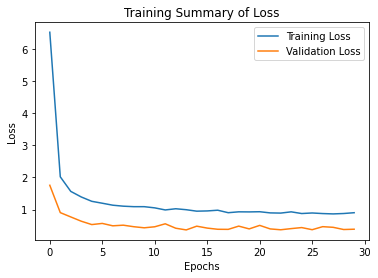

In [30]:
plt.figure()
plt.title("Training Summary of Loss")
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

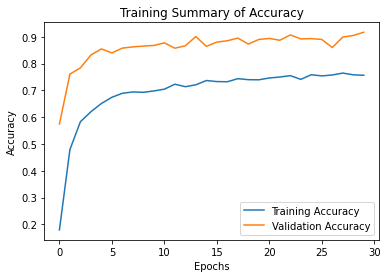

In [31]:
plt.figure()
plt.title("Training Summary of Accuracy")
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### *Question 5: Briefly describe the plots*
The plots show as the number of epochs increase, the training loss and validation loss both decrease; the training accuracy and the validation accuracy both increase.

### 1.8. Predict on the test data with the best model so far

In [34]:
# Predict on the test data

# Load the best model so far
model.load_state_dict(best_model_weights)
test_accuracy = 0

predictions = []
label_data = []

for images, labels in dataloaders['testing']:
    ps = torch.exp(model(images))
    top_ps, top_class = ps.topk(1, dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(
            torch.FloatTensor)
    predictions.append(top_class)
    label_data.append(labels)
    test_accuracy += matches.mean()
    # Try to do similar things as validation to get the test accuracy
    # You also need to store the predictions and labels for all the test data, which will be used later
    # you could save them in predictions and label_data
print('Test Accuracy:', test_accuracy.item() / test_len)

Test Accuracy: 0.8219209909439087


### *Question 6: Report the test accuracy with the best model*
The test accurary with the best model is 0.8219209909439087.

### *Question 7: Provide a confusion matrix between the ground truth and predicted labels in the test dataset. The rows should correspond to the ground ruth categories and the columns to predicted categories. The confusion matrix here should have raw datapoint counts and should not be normalized as percentages*

### *Question 8: Now normalize the raw confusion matrix reported in the previous question by dividing each row by the sum of all its elements. Include this normalized confusion matrix in your report. It may look small but that is fine.*

### *Question 9: What does the diagnal denote in the normalized confusion matrix? What is the meaning of the number in the row 1 column 2?*
    The diagnal in the normalized confusion matrix denotes the number of points where the predicted label is equal to the true label.
    The meaning of the number in the row 1 column 2 denotes a prediction that does not match the true label. 

confusion matrix
[[3 0 0 ... 0 0 1]
 [0 3 0 ... 0 0 0]
 [0 0 8 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]



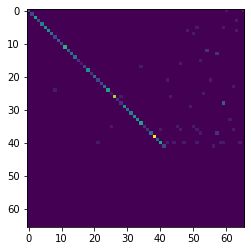

In [41]:
# Please plot the confusion matrix other than print() if possible
from sklearn.metrics import confusion_matrix as conf_mat
import numpy as np
cf = conf_mat(label_data[0], predictions[0])

print('confusion matrix')
print(cf)
print()
plt.imshow(cf)

normalized confusion matrix
[[0.6 0.  0.  ... 0.  0.  0.2]
 [0.  1.  0.  ... 0.  0.  0. ]
 [0.  0.  1.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]


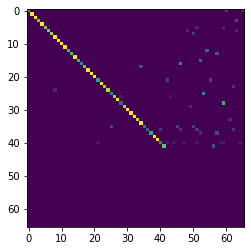

In [42]:
# normalized confusion matrix
print('normalized confusion matrix')
ncf = conf_mat(label_data[0], predictions[0], normalize="true")
print(ncf)
plt.imshow(ncf)

### *Question 10: Transfer Learning*
- What is the purpose of a pretrained model and why should it work?

A pretrained model is trained by a large amount of shared general-domain data, and it is trained to be an initial version of   a model. Thus, pretrained model can be quickly intergrated and requires minimal setup for us to use to train our dataset.
Moreover, by using the pretrained model for our own project, We are also training the pretrained model using a smaller amount   of domain-specific data, containing unlabeled or labeled data, to further refine the model.
 
 
- Why should we freeze the features' gradient in the pretrained model but only update the classifier?

The reason why we should freeze the features' gradient in the pretrained model is that we need to prevent them from changing, and then we unfreeze them and update the classifiers which will be used as feature detectors. Also freezing some of the layers accelerates the training process.
 
 
- What may happen if we do not freeze the features' gradient?
 
The training process will be more time-consuming, and we will risk destroying all the information each layer has already computed.